In [27]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
from pathlib import Path
PROJECT_DIR = Path("/Users/jihoonchoi/Documents/GitHub/Comparative_Optimization_ML").resolve()
DATA_DIR = PROJECT_DIR / "data"
SRC_DIR = PROJECT_DIR / "source"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from optimizers_logreg import fit_gd_fixed, fit_gd_armijo, armijo_backtracking
from models_logreg import sigmoid, logreg_loss_and_grad, fit_logreg, accuracy, predict_label, predict_prob, add_intercept
from models_SVM import svm_loss_and_grad, fit_subgradient, fit_svm_primal, svm_predict_score, svm_predict_label, svm_accuracy, num_support_vectors, add_intercept

# Hard-Margin Support Vector Machine

### Import Dataset

In [11]:
# 1. Load the preprocessed data
train_df = pd.read_csv(DATA_DIR / "train_scaled.csv")
test_df  = pd.read_csv(DATA_DIR / "test_scaled.csv")

# 2. Split into features (X) and target (y)
# Target column is 'def_pay'
X_train = train_df.drop(columns=["def_pay"])
y_train = train_df["def_pay"]

X_test = test_df.drop(columns=["def_pay"])
y_test = test_df["def_pay"]

# --- optional check ---
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Sample features:\n", X_train.head())

Train set: (24000, 26) (24000,)
Test set: (6000, 26) (6000,)
Sample features:
    limit_bal  sex_female       age     pay_1     pay_2     pay_3     pay_4  \
0  -0.676120           1 -1.134519 -0.469497 -0.400043 -0.388863 -0.344641   
1   0.940071           1  1.467205 -0.469497 -0.400043 -0.388863 -0.344641   
2   0.093495           0  0.057938 -0.469497 -0.400043 -0.388863 -0.344641   
3  -0.522197           0 -1.026114 -0.469497 -0.400043 -0.388863 -0.344641   
4  -0.907004           1 -1.459734 -0.469497 -0.400043 -0.388863 -0.344641   

      pay_5     pay_6  bill_amt1  ...  pay_amt2  pay_amt3  pay_amt4  pay_amt5  \
0 -0.312747 -0.319495  -0.081523  ... -0.167625 -0.181802 -0.216587 -0.096648   
1 -0.312747 -0.319495   0.019790  ... -0.175159 -0.183055 -0.184433 -0.186609   
2 -0.312747 -0.319495  -0.634328  ... -0.206593 -0.179296  1.122578 -0.322844   
3 -0.312747 -0.319495   0.546130  ... -0.072370 -0.048563 -0.052200 -0.003012   
4 -0.312747 -0.319495  -0.012369  ... -0.193604

### Training Convergence Summary

In [23]:
# GD with fixed step
theta_gd, info_gd = fit_svm_primal(
    X_train, y_train,
    C = 10, loss = "squared_hinge",
    optimizer = "gd", step = 1e-2,
    tol = 1e-6, max_iter = 50000
)

# GD with Armijo backtracking
theta_armijo, info_armijo = fit_svm_primal(
    X_train, y_train,
    C = 10, loss = "squared_hinge",
    optimizer = "gd_armijo", alpha0 = 1,
    tol = 1e-6, max_iter = 100000
)

# Subgradient on plain hinge (non-smooth)
theta_sub, info_sub = fit_svm_primal(
    X_train, y_train,
    C = 10, loss = "hinge",
    optimizer = "subgrad", alpha0 = 1,
    tol = 1e-6, max_iter = 100000
    )

In [24]:
def last(hist):
    k, f, g = hist[-1]
    return k, f, g

k_gd, f_gd, g_gd = last(info_gd["history"])
k_arm, f_arm, g_arm = last(info_armijo["history"])
k_sub, f_sub, g_sub = last(info_sub["history"])

print(f"GD fixed: iters={k_gd} final loss={f_gd:.6f} grad norm={g_gd:.3e}")
print(f"GD Armijo: iters={k_arm} final loss={f_arm:.6f} grad norm={g_arm:.3e}")
print(f"Subgradient hinge: iters={k_sub} final loss={f_sub:.6f} grad norm={g_sub:.3e}")

GD fixed: iters=3107 final loss=5.819765 grad norm=9.972e-07
GD Armijo: iters=99999 final loss=5.709995 grad norm=2.148e-01
Subgradient hinge: iters=99999 final loss=4.844639 grad norm=5.845e-03


### Convergence Curves

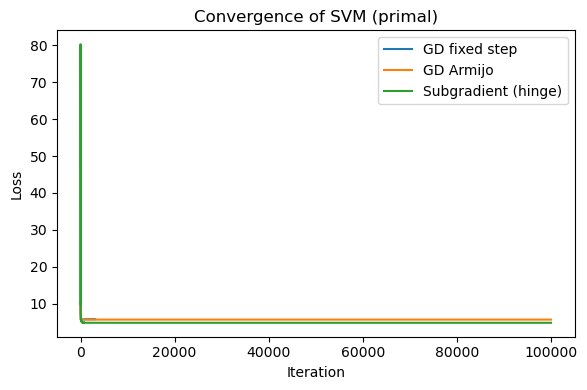

In [25]:
gd_hist = np.array(info_gd["history"])
arm_hist = np.array(info_armijo["history"])
sub_hist = np.array(info_sub["history"])

plt.figure(figsize=(6,4))
plt.plot(gd_hist[:,0],  gd_hist[:,1],  label="GD fixed step")
plt.plot(arm_hist[:,0], arm_hist[:,1], label="GD Armijo")
plt.plot(sub_hist[:,0], sub_hist[:,1], label="Subgradient (hinge)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Convergence of SVM (primal)")
plt.legend()
plt.tight_layout()
plt.show()

### Final Weights & Accuracy

In [26]:
acc_gd = svm_accuracy(theta_gd, X_test, y_test)
acc_arm = svm_accuracy(theta_armijo, X_test, y_test)
acc_sub = svm_accuracy(theta_sub, X_test, y_test)

nsv_gd = num_support_vectors(theta_gd, X_train, y_train)
nsv_arm = num_support_vectors(theta_armijo, X_train, y_train)
nsv_sub = num_support_vectors(theta_sub, X_train, y_train)

print(f"GD fixed accuracy: {acc_gd:.3f} support vectors: {nsv_gd}")
print(f"GD Armijo accuracy: {acc_arm:.3f} support vectors: {nsv_arm}")
print(f"Subgradient accuracy: {acc_sub:.3f} support vectors: {nsv_sub}")

GD fixed accuracy: 0.812 support vectors: 23602
GD Armijo accuracy: 0.812 support vectors: 23703
Subgradient accuracy: 0.804 support vectors: 9690
